<h1 style="text-align: center;"> EE6380 - DEEP LEARNING - ASSIGNMENT 6</h1>
<h2 style="text-align: right;">  ATHARV RAMESH NAIR <br>EE20BTECH11006</h2>

##### Note: For some of the models, I have trained more than once, using lower learning rate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms,models
from torch.utils.data import DataLoader,Subset,Dataset
from sklearn.manifold import TSNE
from torch.utils.data import random_split

## LOADING THE DATASET

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

#
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

train_size = int(0.7 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = int(0.25 * len(train_dataset))

train_dataset, val_dataset,_ = random_split(train_dataset, [train_size, val_size,len(train_dataset)-train_size-val_size])
# test_dataset,_= random_split(test_dataset,[test_size,len(test_dataset)-test_size])


100%|██████████| 170498071/170498071 [00:05<00:00, 32629237.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(f'Size of Training Set : {len(train_dataset)} (70%)')
print(f'Size of Validation Set : {len(val_dataset)} (10%)')
print(f'Size of Testing Set : {len(test_dataset)} (20%)')


Size of Training Set : 35000 (70%)
Size of Validation Set : 5000 (10%)
Size of Testing Set : 10000 (20%)


In [4]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last = False,num_workers =2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,drop_last = False,num_workers =2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8 ,shuffle=False,drop_last = False,num_workers =2,pin_memory=True)
test_loader_bsz_1 = DataLoader(test_dataset,batch_size=1,shuffle=False,drop_last = False,num_workers =2,pin_memory=True)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## TRAINING AND VALIDATION FUNCTION (SIMILAR TO THE ONE USED IN ASSIGNMENT 5)

In [6]:
## Training

def train(model, train_loader, val_loader,optimizer, criterion,epoch,save_path ='best_AlexNet.pth'):

    training_loss = []
    training_accuracy = []

    val_loss = []
    val_accuracy = []
    best_val_accuracy = 0
    best_model = None

    for epoch in range(epoch):
        model.train()
        train_correct = 0
        epoch_loss = 0
        for idx,(img,label) in enumerate(train_loader):

            optimizer.zero_grad()
            img = img.to(device)
            label = label.to(device)
            output,_= model(img)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            prediction = output.argmax(dim=1, keepdim=True)
            train_correct += torch.sum(prediction == label.reshape(prediction.shape)).item()

        training_loss.append(epoch_loss/len(train_loader))

        training_accuracy.append(train_correct/len(train_loader.dataset))

        ## Testing
        model.eval()
        validation_loss = 0
        val_correct = 0
        with torch.no_grad():
            for idx,(img,label) in enumerate(val_loader):
                img = img.to(device)
                label = label.to(device)
                output,_ = model(img)
                loss = criterion(output,label)
                validation_loss += loss.item()
                prediction = output.argmax(dim=1, keepdim=True)
                val_correct += prediction.eq(label.view_as(prediction)).sum().item()

        validation_loss /= len(val_loader)
        val_loss.append(validation_loss)

        accuracy = val_correct/len(val_loader.dataset)
        if accuracy > best_val_accuracy:
          best_val_accuracy = accuracy
          best_model = model
          torch.save(model.state_dict(),save_path)

        val_accuracy.append(accuracy)


        print('Epoch :{:}\tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format((epoch),
          (training_loss[-1]), (training_accuracy[-1]), val_loss[-1], val_accuracy[-1]))


    ## Plotting the training loss and testing loss vs epochs
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.plot(training_loss,label = 'Training Loss')
    plt.plot(val_loss,label = 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy,label = 'Training Accuracy')
    plt.plot(val_accuracy,label = 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f'Best Model Accuracy : {best_val_accuracy}')


    return best_model

    # return


In [7]:
def test_accuracy(model,test_loader):
  model.eval()
  test_correct = 0
  with torch.no_grad():
    for idx,(img,label) in enumerate(test_loader):
      img = img.to(device)
      label = label.to(device)
      output,_ = model(img)
      prediction = output.argmax(dim=1, keepdim=True)
      test_correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_accuracy = test_correct/len(test_loader.dataset)

  print(f"Accuracy on test_set :{test_accuracy}")


### CNN MODEL

In [8]:
class CNN(nn.Module):
  def __init__(self,model= "AlexNet",num_classes = 10):
    super(CNN,self).__init__()
    if model == "AlexNet":
      self.encoder = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
    elif model == "ResNet50":
      self.encoder = models.resnet50(pretrained=False)
    else:
      raise ValueError("choose AlexNet or ResNet50")
    self.final_layer = nn.Linear(1000,num_classes)

  def forward(self,x):
    bottle_neck = self.encoder(x)
    output = self.final_layer(bottle_neck)

    return output,bottle_neck


### USING GOOGLE COLAB TO SAVE AND LOAD MODEL FILES

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = CNN(model ="AlexNet",num_classes = 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00025)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
print(f'Number of Parameters in AlexNet : {sum(p.numel() for p in model.parameters())}')

Number of Parameters in AlexNet : 61110850


### 100 SAMPLES USED FOR PLOTTING TSNE OF BOTTLENECK LAYER

In [23]:
test_subset_indices= []

count = [0]*10
for idx, (img, label) in enumerate(test_loader_bsz_1):
  count[label.item()] += 1
  if count[label.item()] <= 10:
      test_subset_indices.append(idx)


  for i in range(10):
      if count[i] >=10:
          flag = True
      else:
          flag = False
          break
  # print(count)
  if flag:
      break


test_subset_dataset = Subset(test_dataset, test_subset_indices)
test_subset_loader = DataLoader(test_subset_dataset, batch_size=10, shuffle=False,drop_last=False)

In [33]:
def get_bottleneck(model,test_dataloader):

    botlleneck = {}
    model.eval()
    for idx,(img,label) in enumerate(test_dataloader):
      # print(img.shape)
      img = img.to(device)
      _,flat = model(img)
      for i in range(len(flat)):
          botlleneck[flat[i]] = label[i]
      if idx == 125:
        break
    # print(bottleneck)
    botlleneck = sorted(botlleneck.items(), key=lambda x: x[1])
    # print(botlleneck)
    botlleneck = [x[0] for x in botlleneck]
    botlleneck = [x.reshape(1,-1) for x in botlleneck]
    botlleneck = torch.cat(botlleneck)
    return botlleneck.detach().cpu()

initial_bottleneck = get_bottleneck(model,test_subset_loader)

## ACCURACY USING RANDOM INITIALISATION

In [ ]:
test_accuracy(model,test_loader)

Accuracy on test_set :0.1


#### TRAINING USING LR = 0.00025 FOR 40 EPOCHS

Epoch :0	Training Loss: 1.788902 	Training Accuracy: 0.326229 	Validation Loss: 1.452915 	Validation Accuracy: 0.450600
Epoch :1	Training Loss: 1.307099 	Training Accuracy: 0.520971 	Validation Loss: 1.135566 	Validation Accuracy: 0.577200
Epoch :2	Training Loss: 1.099164 	Training Accuracy: 0.602029 	Validation Loss: 0.970384 	Validation Accuracy: 0.642400
Epoch :3	Training Loss: 0.915437 	Training Accuracy: 0.675429 	Validation Loss: 0.892874 	Validation Accuracy: 0.680600
Epoch :4	Training Loss: 0.790427 	Training Accuracy: 0.719571 	Validation Loss: 0.786972 	Validation Accuracy: 0.714800
Epoch :5	Training Loss: 0.693170 	Training Accuracy: 0.757686 	Validation Loss: 0.759520 	Validation Accuracy: 0.740000
Epoch :6	Training Loss: 0.591227 	Training Accuracy: 0.793286 	Validation Loss: 0.745724 	Validation Accuracy: 0.739800
Epoch :7	Training Loss: 0.520400 	Training Accuracy: 0.817371 	Validation Loss: 0.774044 	Validation Accuracy: 0.730800
Epoch :8	Training Loss: 0.458663 	Traini

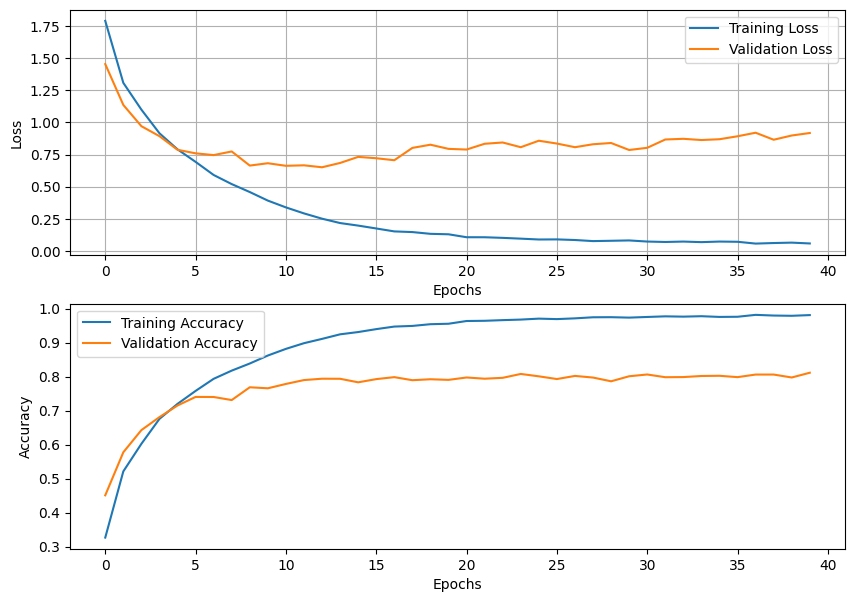

Best Model Accuracy : 0.8112


In [ ]:
best_model = train(model,train_loader,val_loader,optimizer,criterion,epoch = 40)

#### ACCURACY AFTER 40 EPOCHS

In [ ]:
test_accuracy(model,test_loader)

Accuracy on test_set :0.821


#### TRAINING AT LR = 0.00005 FOR 20 EPOCHS

Epoch :0	Training Loss: 0.175572 	Training Accuracy: 0.948086 	Validation Loss: 0.163075 	Validation Accuracy: 0.949800
Epoch :1	Training Loss: 0.141430 	Training Accuracy: 0.957629 	Validation Loss: 0.167085 	Validation Accuracy: 0.949800
Epoch :2	Training Loss: 0.113215 	Training Accuracy: 0.964543 	Validation Loss: 0.165787 	Validation Accuracy: 0.949000
Epoch :3	Training Loss: 0.089133 	Training Accuracy: 0.972143 	Validation Loss: 0.170638 	Validation Accuracy: 0.950400
Epoch :4	Training Loss: 0.071471 	Training Accuracy: 0.976857 	Validation Loss: 0.180733 	Validation Accuracy: 0.949800
Epoch :5	Training Loss: 0.062692 	Training Accuracy: 0.979714 	Validation Loss: 0.183846 	Validation Accuracy: 0.950400
Epoch :6	Training Loss: 0.049256 	Training Accuracy: 0.983714 	Validation Loss: 0.190963 	Validation Accuracy: 0.949600
Epoch :7	Training Loss: 0.041760 	Training Accuracy: 0.986400 	Validation Loss: 0.201234 	Validation Accuracy: 0.950200
Epoch :8	Training Loss: 0.034963 	Traini

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch :12	Training Loss: 0.023424 	Training Accuracy: 0.992029 	Validation Loss: 0.236687 	Validation Accuracy: 0.949600


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch :13	Training Loss: 0.021714 	Training Accuracy: 0.992371 	Validation Loss: 0.249790 	Validation Accuracy: 0.951600


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x79d4ddb8e560>    if w.is_alive():
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
:     can only test a child processif w.is_alive():

  File "/usr/lib/

Epoch :14	Training Loss: 0.019689 	Training Accuracy: 0.993371 	Validation Loss: 0.242082 	Validation Accuracy: 0.949800
Epoch :15	Training Loss: 0.019804 	Training Accuracy: 0.993229 	Validation Loss: 0.244771 	Validation Accuracy: 0.948800
Epoch :16	Training Loss: 0.016323 	Training Accuracy: 0.994971 	Validation Loss: 0.253045 	Validation Accuracy: 0.949400
Epoch :17	Training Loss: 0.016133 	Training Accuracy: 0.994971 	Validation Loss: 0.257918 	Validation Accuracy: 0.950000
Epoch :18	Training Loss: 0.015688 	Training Accuracy: 0.995029 	Validation Loss: 0.253893 	Validation Accuracy: 0.951600
Epoch :19	Training Loss: 0.015974 	Training Accuracy: 0.994857 	Validation Loss: 0.252772 	Validation Accuracy: 0.949000


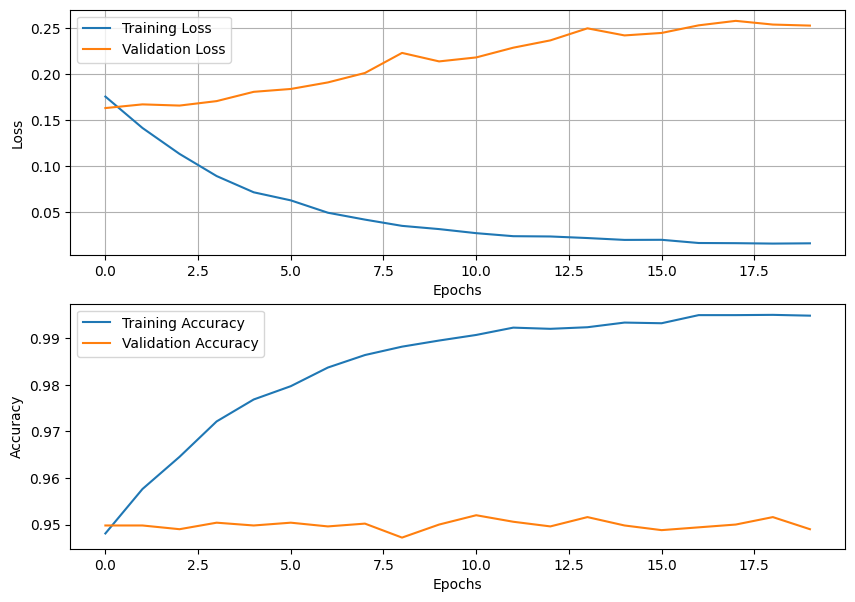

Best Model Accuracy : 0.952


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00005)
best_model = train(model,train_loader,val_loader,optimizer,criterion,epoch = 20)

In [ ]:
save_path = '/content/drive/MyDrive/best_AlexNet.pth'
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### FINAL ACCURACY

In [ ]:
test_accuracy(model,test_loader)

Accuracy on test_set :0.8324


### BOTTLENECK TO PLOT TSNE

In [ ]:
final_bottleneck = get_bottleneck(model,test_subset_loader)

In [ ]:
def display_activation_map_alexNet(model,input):
  feature = model.encoder.features

  x = input
  for i in range(1):
    x = feature[i](x)
  # print(x.shape)
  ## Pick 10 channels to display

  plt.figure(figsize = (12,4))
  plt.subplot(2,5,1)
  plt.title('Upsampled Image')
  plt.axis('off')
  img = input.detach().cpu().numpy()
  img = img.transpose(1,0,2).transpose(0,2,1)
  plt.imshow(img)
  for i in range(9):
    plt.subplot(2,5,i+2)
    plt.imshow(x[i*5].detach().cpu().numpy(),cmap='gray')
    plt.title(f'channel = {i*5}')
    plt.axis('off')

  plt.show()


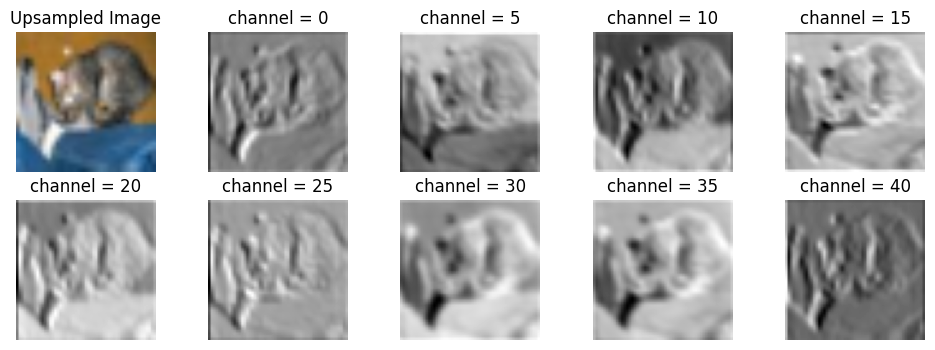

In [ ]:
img,label = next(iter(test_loader))
img = img[0].to(device)
display_activation_map_alexNet(model,img)

In [34]:
def plot_tsne(flat_vanilla_initial, flat_vanilla_final):

    combined = np.concatenate((flat_vanilla_initial, flat_vanilla_final), axis=0)

    labels = np.repeat(np.arange(10), 10)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    transformed_data = tsne.fit_transform(combined)
    # print(transformed_data.shape)
    n = len(transformed_data)
    transformed_initial = transformed_data[:n//2, :]
    transformed_final = transformed_data[n//2:, :]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    for i in range(10):
        plt.scatter(transformed_initial[labels == i, 0], transformed_initial[labels == i, 1], label=f'Class {i}')
    plt.title('t-SNE Visualization - Initial Features')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(10):
        plt.scatter(transformed_final[labels == i, 0], transformed_final[labels == i, 1], label=f'Class {i}')
    plt.title('t-SNE Visualization - Final Features')
    plt.legend()

    plt.show()

#### TSNE FOR BOTTLENECK LAYER (BEFORE AND AFTER TRAINING - ALEXNET)

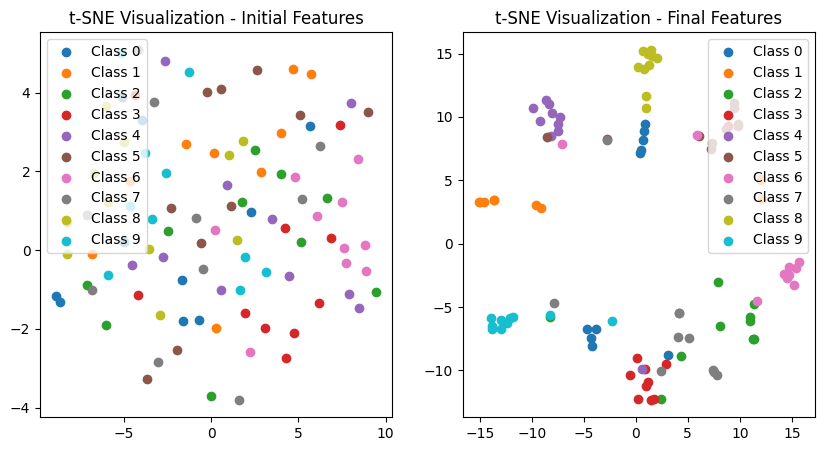

In [ ]:
plot_tsne(initial_bottleneck,final_bottleneck)

## RESNET

In [9]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last = False,num_workers =2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,drop_last = False,num_workers =2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8 ,shuffle=False,drop_last = False,num_workers =2,pin_memory=True)

In [28]:
model = CNN(model = "ResNet50",num_classes = 10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
print("Number of Parameters in ResNet: ",sum(p.numel() for p in model.parameters()))

Number of Parameters in ResNet:  25567042


### INITIAL ACCURACY

In [29]:
test_accuracy(model,test_loader)
initial_resnet_bottleneck = get_bottleneck(model,test_subset_loader)

Accuracy on test_set :0.1


#### TRAINING FOR 20 EPOCHS WITH LR = 0.0005

Epoch :0	Training Loss: 1.824387 	Training Accuracy: 0.330314 	Validation Loss: 1.601899 	Validation Accuracy: 0.416200
Epoch :1	Training Loss: 1.275987 	Training Accuracy: 0.531743 	Validation Loss: 1.269793 	Validation Accuracy: 0.552200
Epoch :2	Training Loss: 1.029033 	Training Accuracy: 0.630200 	Validation Loss: 1.124557 	Validation Accuracy: 0.596600
Epoch :3	Training Loss: 0.848332 	Training Accuracy: 0.697057 	Validation Loss: 1.316034 	Validation Accuracy: 0.645400
Epoch :4	Training Loss: 0.725520 	Training Accuracy: 0.744943 	Validation Loss: 0.775654 	Validation Accuracy: 0.726400
Epoch :5	Training Loss: 0.601937 	Training Accuracy: 0.787771 	Validation Loss: 0.701861 	Validation Accuracy: 0.753400
Epoch :6	Training Loss: 0.503041 	Training Accuracy: 0.825571 	Validation Loss: 0.671974 	Validation Accuracy: 0.769000
Epoch :7	Training Loss: 0.422532 	Training Accuracy: 0.852829 	Validation Loss: 0.675764 	Validation Accuracy: 0.771200
Epoch :8	Training Loss: 0.349896 	Traini

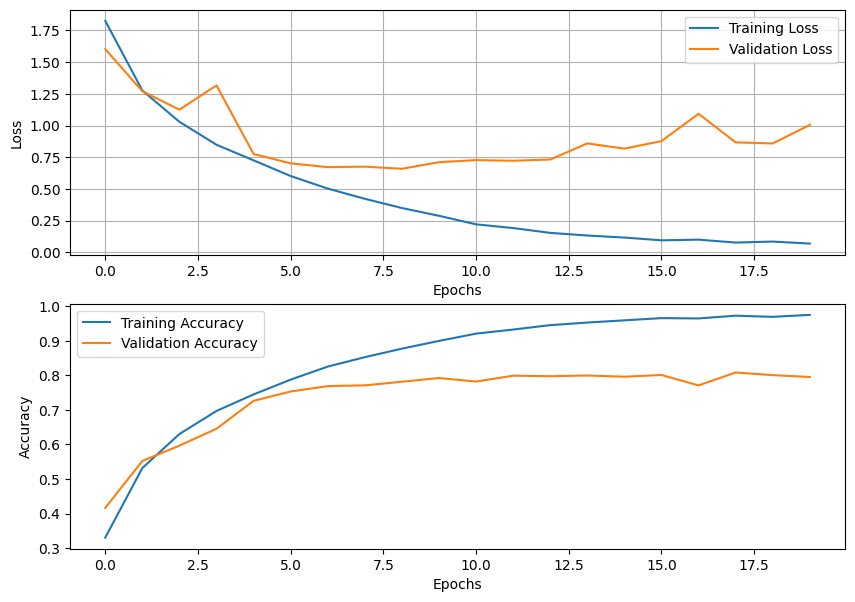

In [ ]:
best_resnet_model = train(model,train_loader,val_loader,optimizer,criterion,epoch = 20,save_path ='best_resnet.pth')

#### TRAINING FOR 5 EPOCHS WITH LR = 0.0001

Epoch :0	Training Loss: 0.014412 	Training Accuracy: 0.995371 	Validation Loss: 0.915741 	Validation Accuracy: 0.832800
Epoch :1	Training Loss: 0.003750 	Training Accuracy: 0.998943 	Validation Loss: 1.016057 	Validation Accuracy: 0.828000
Epoch :2	Training Loss: 0.005101 	Training Accuracy: 0.998257 	Validation Loss: 1.160962 	Validation Accuracy: 0.823200
Epoch :3	Training Loss: 0.006478 	Training Accuracy: 0.997914 	Validation Loss: 1.134660 	Validation Accuracy: 0.822400
Epoch :4	Training Loss: 0.004509 	Training Accuracy: 0.998514 	Validation Loss: 1.158387 	Validation Accuracy: 0.827000


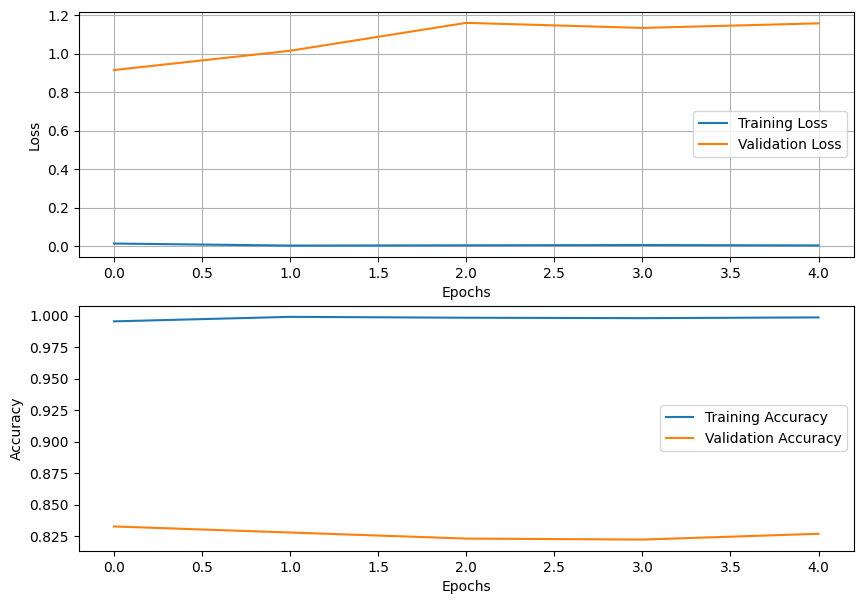

Best Model Accuracy : 0.8328


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
best_resnet_model = train(model,train_loader,val_loader,optimizer,criterion,epoch = 5,save_path ='best_resnet.pth')

### TRAIN FOR 5 EPOCHS WITH LR = 0.00005

Epoch :0	Training Loss: 0.211135 	Training Accuracy: 0.949343 	Validation Loss: 0.170728 	Validation Accuracy: 0.952800
Epoch :1	Training Loss: 0.123088 	Training Accuracy: 0.963400 	Validation Loss: 0.166339 	Validation Accuracy: 0.952200
Epoch :2	Training Loss: 0.089113 	Training Accuracy: 0.973257 	Validation Loss: 0.174159 	Validation Accuracy: 0.954000
Epoch :3	Training Loss: 0.056490 	Training Accuracy: 0.983057 	Validation Loss: 0.196414 	Validation Accuracy: 0.951800
Epoch :4	Training Loss: 0.033274 	Training Accuracy: 0.990886 	Validation Loss: 0.225451 	Validation Accuracy: 0.947800


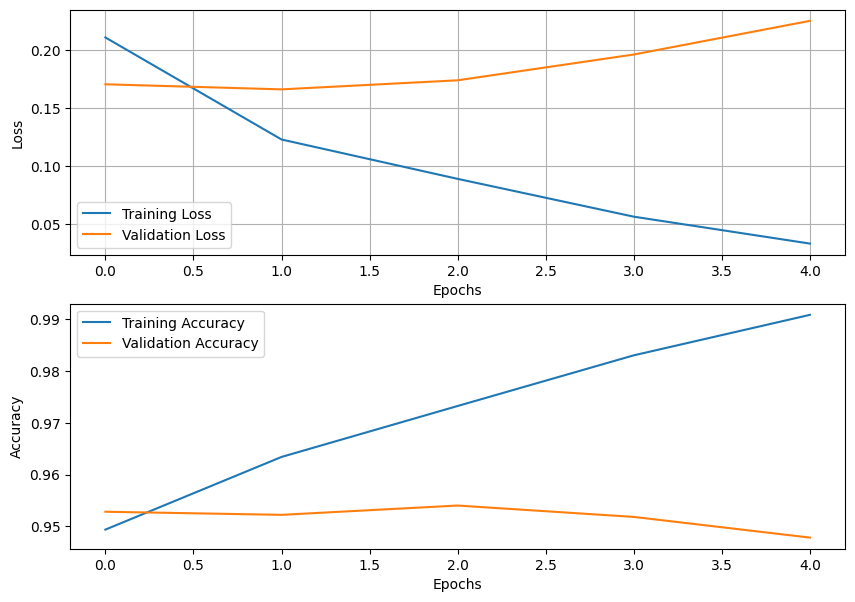

Best Model Accuracy : 0.954


In [17]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00005)
best_resnet_model = train(model,train_loader,val_loader,optimizer,criterion,epoch = 5,save_path ='best_resnet.pth')

### FINAL ACCURACY

In [30]:
save_path = '/content/drive/MyDrive/best_resnet.pth'
model.load_state_dict(torch.load(save_path))
test_accuracy(model,test_loader)

Accuracy on test_set :0.8433


In [27]:
torch.save(model.state_dict(),save_path)

In [19]:
def display_resnet_activation_map(model,input):
  encoder = model.encoder
  x = encoder.conv1(input.unsqueeze(0))
  x = encoder.bn1(x)
  x = encoder.relu(x)
  x = encoder.maxpool(x)

  x = encoder.layer1[0](x)[0]

  plt.figure(figsize = (12,4))
  plt.subplot(2,5,1)
  plt.title('Upsampled Image')
  plt.axis('off')
  img = input.detach().cpu().numpy()
  img = img.transpose(1,0,2).transpose(0,2,1)
  plt.imshow(img)
  for i in range(9):
    plt.subplot(2,5,i+2)
    plt.imshow(x[i*5].detach().cpu().numpy(),cmap='gray')
    plt.title(f'channel = {i*5}')
    plt.axis('off')

  plt.show()


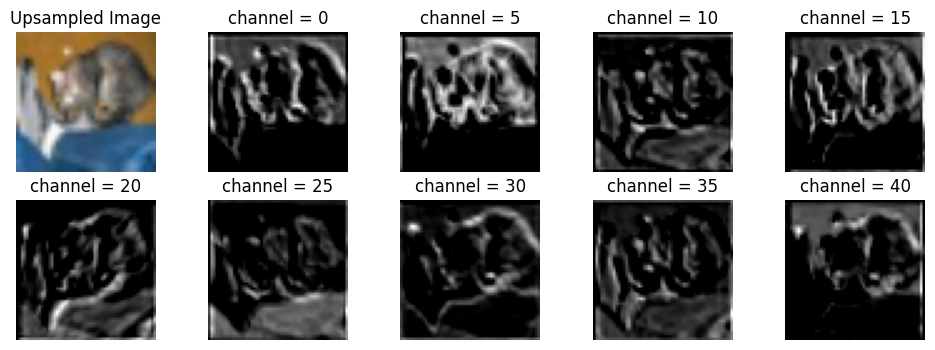

In [20]:
img,label = next(iter(test_loader))
img = img[0].to(device)
display_resnet_activation_map(model,img)

In [31]:
final_resnet_bottleneck = get_bottleneck(model,test_subset_loader)

### TSNE PLOT (BEFORE AND AFTER TRAINING - RESNET50)

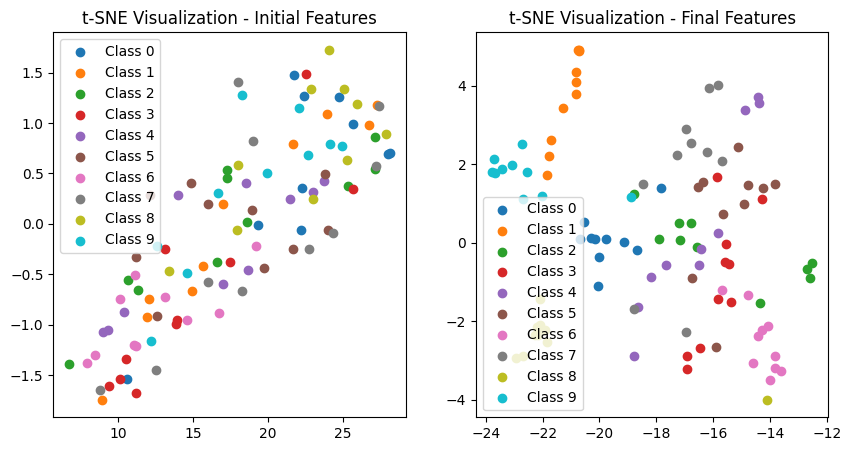

In [35]:
plot_tsne(initial_resnet_bottleneck,final_resnet_bottleneck)

### Accuracy using AlexNet : 0.83
### Accuracy using ResNet50 : 0.84

#### Both ResNet and AlexNet achieve similar performance.  Time taken to train AlexNet per epoch was much less compared to ResNet. Given the complexity of ResNet, it would probably need more epochs to show better results
#### Because of the increased complexity, ResNet was trained only for 30 epochs whereas AlexNet was trained for 60 epochs. Given this, the performance of both models is quite similar
#### If ResNet50 was trained for 60 epochs, the performace would possibly improve significantly
#### AlexNet should be preferred if we want to quickly train a model, but for better performance, ResNet50 should be preferred

# TIME SERIES MODELS

In [3]:
from io import open
import glob
import os
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### DATA PREPERATION

### Rather than directly following the tutorial directly, I have used the more traditional approach using dataloaders. This ensures the entire dataset is used for training . In the tutorial, a random sample was generated every time which doesnt ensure the usage of the entire dataset. A separate test dataset has been created to compute accuracy

In [4]:
def findFiles(path): return glob.glob(path)

# print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    # print(os.path.basename(filename))
    category = os.path.splitext(os.path.basename(filename))[0]
    # print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), n_letters)
    for li, letter in enumerate(line):
        tensor[li][letterToIndex(letter)] = 1
    return tensor

In [6]:
## Create Test and Train Data
split_ratio = 0.8
train_category_lines = {}
test_category_lines = {}
for category in all_categories:
    lines = category_lines[category]
    random.shuffle(lines)
    train_category_lines[category] = lines[:int(len(lines)*split_ratio)]
    test_category_lines[category] = lines[int(len(lines)*split_ratio):]

In [7]:
class Names_Dataset(Dataset):
    def __init__(self, category_lines, all_categories):
        self.category_lines = category_lines
        self.all_categories = all_categories
        self.n_categories = len(all_categories)
        self.data = self._prepare_data()

    def _prepare_data(self):
        data = []
        for i, category in enumerate(self.all_categories):
            lines = self.category_lines[category]

            for line in lines:
                sequence = lineToTensor(line)
                data.append((sequence, i))  # (input_sequence, target_category_index)
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_sequence, target_category_index = self.data[index]
        # one_hot_sequence = lineToTensor(input_sequence)
        return input_sequence, target_category_index


In [8]:
train_dataset = Names_Dataset(train_category_lines, all_categories)
test_dataset = Names_Dataset(test_category_lines, all_categories)

In [9]:
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
## Training

def train(model, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128,LSTM = False):

    training_loss = []
    training_accuracy = []

    testing_loss = []
    testing_accuracy = []
    
    for epoch in range(epoch):
        model.train()
        train_correct = 0 
        epoch_loss = 0
        for idx,(input_sequence,label) in enumerate(train_loader):

            optimizer.zero_grad()

            bsz = input_sequence.shape[0]
            if not LSTM:
                hidden = torch.zeros(bsz,1,hidden_size)
                output,hidden= model(input_sequence,hidden)
            else:
                hidden = (torch.zeros(1,bsz,hidden_size),torch.zeros(1,bsz,hidden_size))
                output,hidden= model(input_sequence,hidden)
            loss = criterion(output,label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            prediction = output.argmax(dim=1, keepdim=True)
         
            train_correct += torch.sum(prediction == label.reshape(prediction.shape)).item()
        training_loss.append(epoch_loss/len(train_loader))
        training_accuracy.append(train_correct/len(train_loader.dataset))
       

        ## Testing
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for idx,(input_sequence,label) in enumerate(test_loader):
                bsz = input_sequence.shape[0]
                if not LSTM:
                    hidden = torch.zeros(bsz,1,hidden_size)
                    output,hidden= model(input_sequence,hidden)
                else:
                    hidden = (torch.zeros(1,bsz,hidden_size),torch.zeros(1,bsz,hidden_size))
                    output,hidden= model(input_sequence,hidden)
                test_loss += criterion(output,label).item()
                prediction = output.argmax(dim=1, keepdim=True)
                correct += prediction.eq(label.view_as(prediction)).sum().item()

        test_loss /= len(test_loader)
        testing_loss.append(test_loss)
        testing_accuracy.append(correct/len(test_loader.dataset))

        print('Epoch {:} Training Loss: {:.6f} \tTraining Accuracy: {:.6f} \tTesting Loss: {:.6f} \tTesting Accuracy: {:.6f}'.format((epoch),
        (training_loss[-1]), (training_accuracy[-1]), testing_loss[-1], testing_accuracy[-1]))
        
    
    ## Plotting the training loss and testing loss vs epochs
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 1, 1)
    plt.grid(True)
    plt.plot(training_loss,label = 'Training Loss')
    plt.plot(testing_loss,label = 'Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(training_accuracy,label = 'Training Accuracy')
    plt.plot(testing_accuracy,label = 'Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return training_loss,training_accuracy,testing_loss,testing_accuracy

    # return

In [13]:
class RNN(nn.Module):

    def __init__(self,num_categories):
        super(RNN,self).__init__()
        self.input_size = n_letters
        self.hidden_size = 128
        self.output_size = num_categories

        self.rnn = nn.RNN(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=1,batch_first=True)
        self.fc = nn.Linear(self.hidden_size,self.output_size)

    def forward(self,input,hidden):

        output,hidden = self.rnn(input,hidden)
        output = self.fc(output[:,-1,:])
        return output,hidden
    
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers,batch_size,self.hidden_size)
        return hidden

Epoch 0 Training Loss: 1.156038 	Training Accuracy: 0.655018 	Testing Loss: 1.027520 	Testing Accuracy: 0.692862
Epoch 1 Training Loss: 0.944040 	Training Accuracy: 0.715567 	Testing Loss: 0.965308 	Testing Accuracy: 0.706541
Epoch 2 Training Loss: 0.865530 	Training Accuracy: 0.740049 	Testing Loss: 0.891210 	Testing Accuracy: 0.732405
Epoch 3 Training Loss: 0.815115 	Training Accuracy: 0.750576 	Testing Loss: 0.869026 	Testing Accuracy: 0.737379
Epoch 4 Training Loss: 0.801808 	Training Accuracy: 0.752819 	Testing Loss: 0.850823 	Testing Accuracy: 0.748570
Epoch 5 Training Loss: 0.769322 	Training Accuracy: 0.766274 	Testing Loss: 0.863902 	Testing Accuracy: 0.744094
Epoch 6 Training Loss: 0.772173 	Training Accuracy: 0.763222 	Testing Loss: 0.918835 	Testing Accuracy: 0.722954
Epoch 7 Training Loss: 0.773223 	Training Accuracy: 0.766461 	Testing Loss: 0.839911 	Testing Accuracy: 0.753047
Epoch 8 Training Loss: 0.775415 	Training Accuracy: 0.763284 	Testing Loss: 0.928773 	Testing Ac

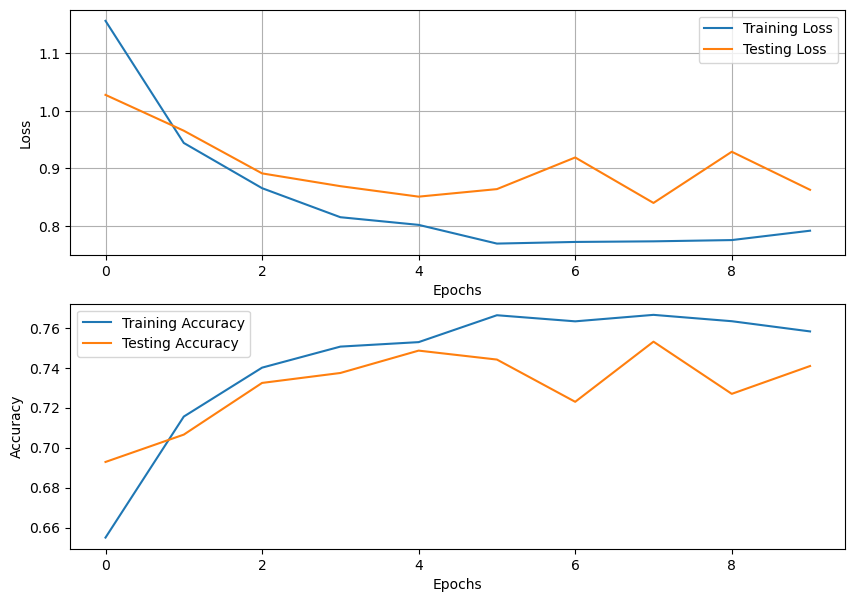

In [15]:
rnn = RNN(n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
epoch = 10
_ = train(rnn, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128)

Epoch 0 Training Loss: 0.641653 	Training Accuracy: 0.800723 	Testing Loss: 0.736353 	Testing Accuracy: 0.776175
Epoch 1 Training Loss: 0.555880 	Training Accuracy: 0.825266 	Testing Loss: 0.723703 	Testing Accuracy: 0.784879
Epoch 2 Training Loss: 0.508715 	Training Accuracy: 0.835358 	Testing Loss: 0.707964 	Testing Accuracy: 0.788610
Epoch 3 Training Loss: 0.472734 	Training Accuracy: 0.851056 	Testing Loss: 0.713815 	Testing Accuracy: 0.786123
Epoch 4 Training Loss: 0.442913 	Training Accuracy: 0.856787 	Testing Loss: 0.711659 	Testing Accuracy: 0.788858
Epoch 5 Training Loss: 0.415235 	Training Accuracy: 0.864885 	Testing Loss: 0.732703 	Testing Accuracy: 0.788610
Epoch 6 Training Loss: 0.393269 	Training Accuracy: 0.871239 	Testing Loss: 0.728849 	Testing Accuracy: 0.792838
Epoch 7 Training Loss: 0.371889 	Training Accuracy: 0.878091 	Testing Loss: 0.738411 	Testing Accuracy: 0.789356
Epoch 8 Training Loss: 0.350934 	Training Accuracy: 0.885753 	Testing Loss: 0.744473 	Testing Ac

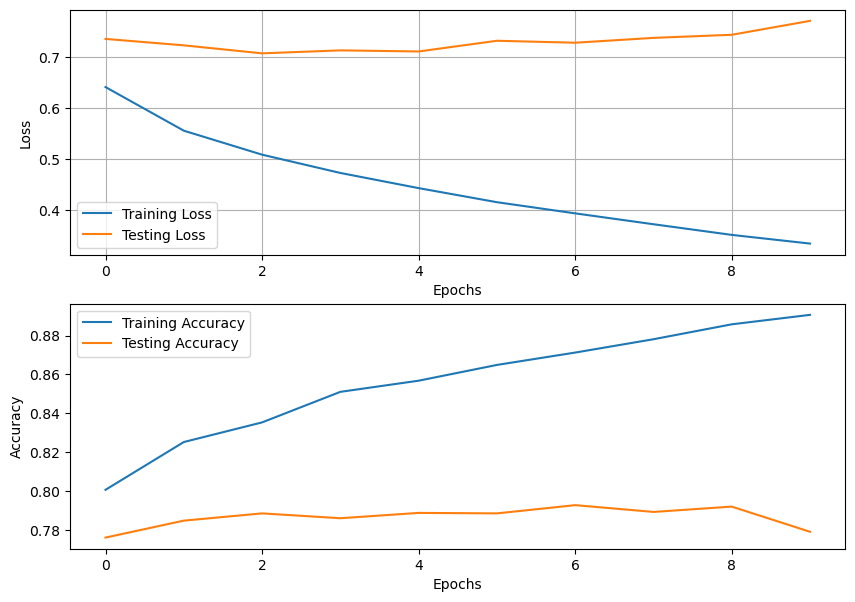

In [16]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.00025)
epoch = 10
_ = train(rnn, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128)

Epoch 0 Training Loss: 0.273644 	Training Accuracy: 0.911979 	Testing Loss: 0.753220 	Testing Accuracy: 0.791594
Epoch 1 Training Loss: 0.247891 	Training Accuracy: 0.920887 	Testing Loss: 0.764322 	Testing Accuracy: 0.781398
Epoch 2 Training Loss: 0.232806 	Training Accuracy: 0.926680 	Testing Loss: 0.775292 	Testing Accuracy: 0.789107
Epoch 3 Training Loss: 0.222416 	Training Accuracy: 0.927615 	Testing Loss: 0.784079 	Testing Accuracy: 0.786869
Epoch 4 Training Loss: 0.210853 	Training Accuracy: 0.933782 	Testing Loss: 0.795309 	Testing Accuracy: 0.785874


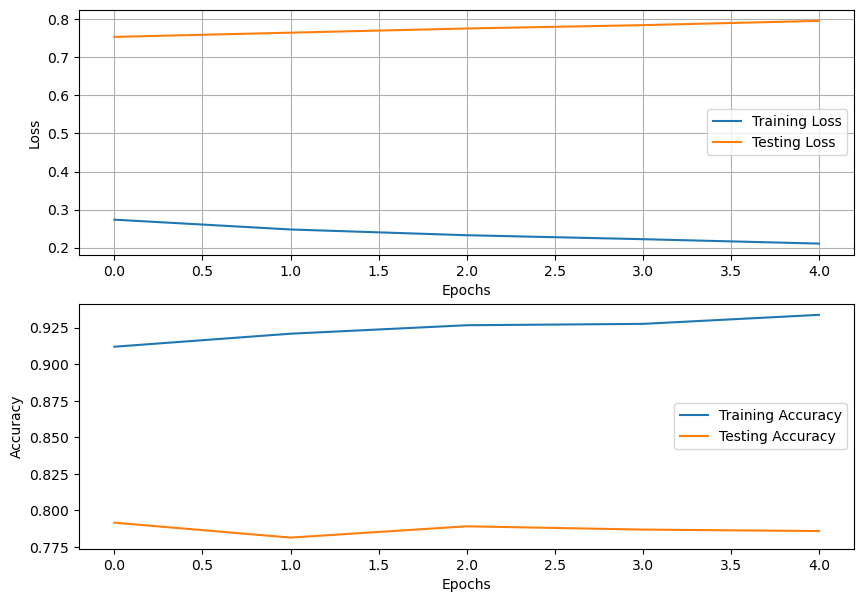

In [17]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001)
epoch = 5
_ = train(rnn, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128)

In [18]:
torch.save(rnn.state_dict(),"rnn.pth")

In [20]:
class GRU(nn.Module):
    def __init__(self,num_categories):
        super(GRU,self).__init__()
        self.input_size = n_letters
        self.hidden_size = 128
        self.output_size = num_categories

        self.rnn = nn.GRU(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=1,batch_first=True)
        self.fc = nn.Linear(self.hidden_size,self.output_size)

    def forward(self,input,hidden):

        output,hidden = self.rnn(input,hidden)
        output = self.fc(output[:,-1,:])
        return output,hidden

Epoch 0 Training Loss: 0.987654 	Training Accuracy: 0.706223 	Testing Loss: 0.810911 	Testing Accuracy: 0.749813
Epoch 1 Training Loss: 0.651120 	Training Accuracy: 0.798418 	Testing Loss: 0.666202 	Testing Accuracy: 0.793584
Epoch 2 Training Loss: 0.519520 	Training Accuracy: 0.834174 	Testing Loss: 0.606352 	Testing Accuracy: 0.814225
Epoch 3 Training Loss: 0.435306 	Training Accuracy: 0.858095 	Testing Loss: 0.591616 	Testing Accuracy: 0.822681
Epoch 4 Training Loss: 0.368953 	Training Accuracy: 0.881206 	Testing Loss: 0.591021 	Testing Accuracy: 0.829396
Epoch 5 Training Loss: 0.308818 	Training Accuracy: 0.895596 	Testing Loss: 0.633679 	Testing Accuracy: 0.819448
Epoch 6 Training Loss: 0.263466 	Training Accuracy: 0.913723 	Testing Loss: 0.659954 	Testing Accuracy: 0.824670
Epoch 7 Training Loss: 0.232469 	Training Accuracy: 0.922631 	Testing Loss: 0.668518 	Testing Accuracy: 0.822432
Epoch 8 Training Loss: 0.206939 	Training Accuracy: 0.930480 	Testing Loss: 0.718346 	Testing Ac

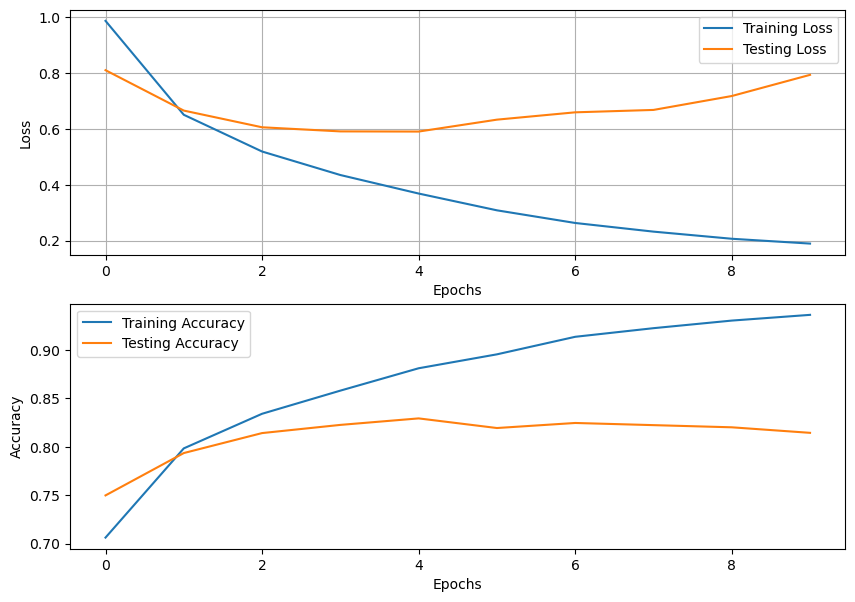

([0.9876538115738835,
  0.6511202555022034,
  0.5195201934308871,
  0.43530560674500796,
  0.36895264846148645,
  0.30881760183138046,
  0.2634657609420404,
  0.23246922315659851,
  0.20693932663750206,
  0.18963626418893084],
 [0.7062231358624557,
  0.7984177412321685,
  0.8341742976390706,
  0.8580950601133744,
  0.8812060051080794,
  0.8955958387840279,
  0.9137232915965863,
  0.9226312838721734,
  0.9304802840590544,
  0.9363981810253535],
 [0.8109108750445095,
  0.6662016707553122,
  0.6063523635080208,
  0.5916161310301824,
  0.5910211036860181,
  0.6336793649490138,
  0.6599536356546712,
  0.6685175902303656,
  0.7183464031327542,
  0.7941992472708783],
 [0.7498134792340214,
  0.7935836856503358,
  0.8142253170853022,
  0.8226809251429993,
  0.8293956727182293,
  0.8194478985327033,
  0.8246704799801045,
  0.8224322307883611,
  0.8201939815966177,
  0.8144740114399404])

In [21]:
gru = GRU(n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.001)
epoch = 10
train(gru, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128)

Epoch 0 Training Loss: 0.115559 	Training Accuracy: 0.959135 	Testing Loss: 0.750205 	Testing Accuracy: 0.824173
Epoch 1 Training Loss: 0.094726 	Training Accuracy: 0.962437 	Testing Loss: 0.769409 	Testing Accuracy: 0.819945
Epoch 2 Training Loss: 0.088596 	Training Accuracy: 0.962686 	Testing Loss: 0.787932 	Testing Accuracy: 0.821437
Epoch 3 Training Loss: 0.083753 	Training Accuracy: 0.964057 	Testing Loss: 0.808315 	Testing Accuracy: 0.824670
Epoch 4 Training Loss: 0.081525 	Training Accuracy: 0.963496 	Testing Loss: 0.811260 	Testing Accuracy: 0.821189


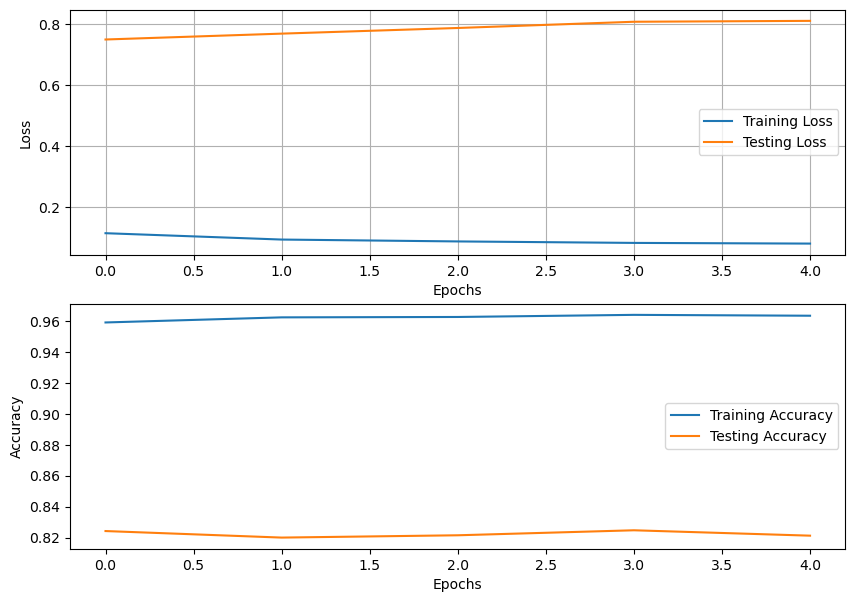

([0.11555931602619694,
  0.09472642495476606,
  0.08859560026348082,
  0.08375323902724031,
  0.08152519846772216],
 [0.9591353641063975,
  0.9624369276770697,
  0.962686102286177,
  0.9640565626362674,
  0.9634959197657759],
 [0.7502051144318139,
  0.7694088372303665,
  0.7879319234880446,
  0.8083150989876534,
  0.8112595774306081],
 [0.8241730912708282,
  0.8199452872419796,
  0.8214374533698086,
  0.8246704799801045,
  0.8211887590151704])

In [22]:
optimizer = torch.optim.Adam(gru.parameters(), lr=0.00025)
epoch = 5
train(gru, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128)

In [11]:
class LSTM(nn.Module):
    def __init__(self,num_categories):
        super(LSTM,self).__init__()
        self.input_size = n_letters
        self.hidden_size = 128
        self.output_size = num_categories

        self.rnn = nn.LSTM(input_size=self.input_size,hidden_size=self.hidden_size,num_layers=1,batch_first=True)
        self.fc = nn.Linear(self.hidden_size,self.output_size)

    def forward(self,input,hidden):

        output,hidden = self.rnn(input,hidden)
        output = self.fc(output[:,-1,:])
        return output,hidden

Epoch 0 Training Loss: 1.073034 	Training Accuracy: 0.681617 	Testing Loss: 0.879994 	Testing Accuracy: 0.725939
Epoch 1 Training Loss: 0.714566 	Training Accuracy: 0.782284 	Testing Loss: 0.722334 	Testing Accuracy: 0.784631
Epoch 2 Training Loss: 0.573773 	Training Accuracy: 0.821404 	Testing Loss: 0.663906 	Testing Accuracy: 0.796319
Epoch 3 Training Loss: 0.478350 	Training Accuracy: 0.846072 	Testing Loss: 0.613472 	Testing Accuracy: 0.812484
Epoch 4 Training Loss: 0.403497 	Training Accuracy: 0.868498 	Testing Loss: 0.606800 	Testing Accuracy: 0.821686
Epoch 5 Training Loss: 0.337218 	Training Accuracy: 0.889429 	Testing Loss: 0.629015 	Testing Accuracy: 0.823178
Epoch 6 Training Loss: 0.285425 	Training Accuracy: 0.905501 	Testing Loss: 0.658025 	Testing Accuracy: 0.817458
Epoch 7 Training Loss: 0.241023 	Training Accuracy: 0.918894 	Testing Loss: 0.692002 	Testing Accuracy: 0.813728
Epoch 8 Training Loss: 0.210724 	Training Accuracy: 0.929608 	Testing Loss: 0.705368 	Testing Ac

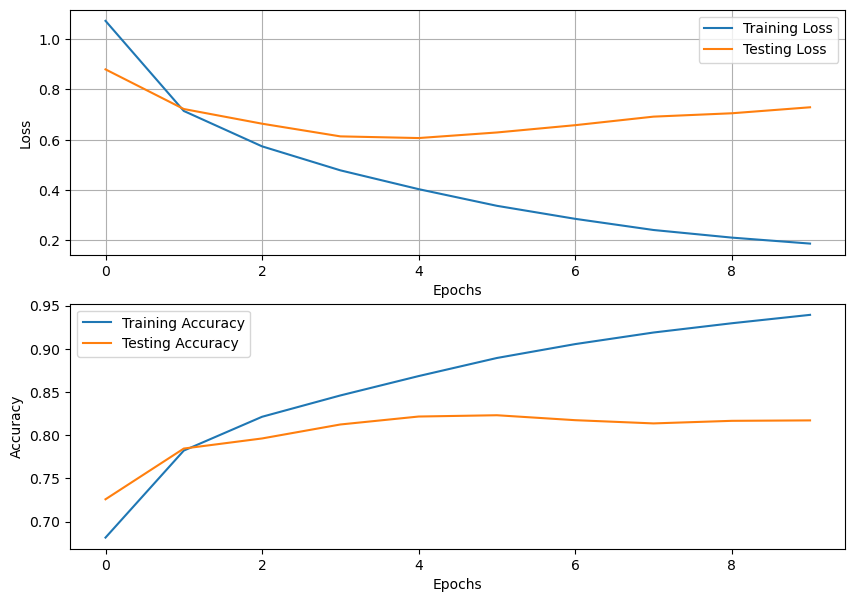

In [12]:
lstm= LSTM(n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
epoch = 10
_ = train(lstm, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128,LSTM = True)

Epoch 0 Training Loss: 0.115544 	Training Accuracy: 0.963558 	Testing Loss: 0.742517 	Testing Accuracy: 0.821686
Epoch 1 Training Loss: 0.090502 	Training Accuracy: 0.968293 	Testing Loss: 0.767230 	Testing Accuracy: 0.820691
Epoch 2 Training Loss: 0.080817 	Training Accuracy: 0.968479 	Testing Loss: 0.794624 	Testing Accuracy: 0.821686
Epoch 3 Training Loss: 0.075473 	Training Accuracy: 0.968355 	Testing Loss: 0.808530 	Testing Accuracy: 0.820194
Epoch 4 Training Loss: 0.072061 	Training Accuracy: 0.968230 	Testing Loss: 0.829728 	Testing Accuracy: 0.818204


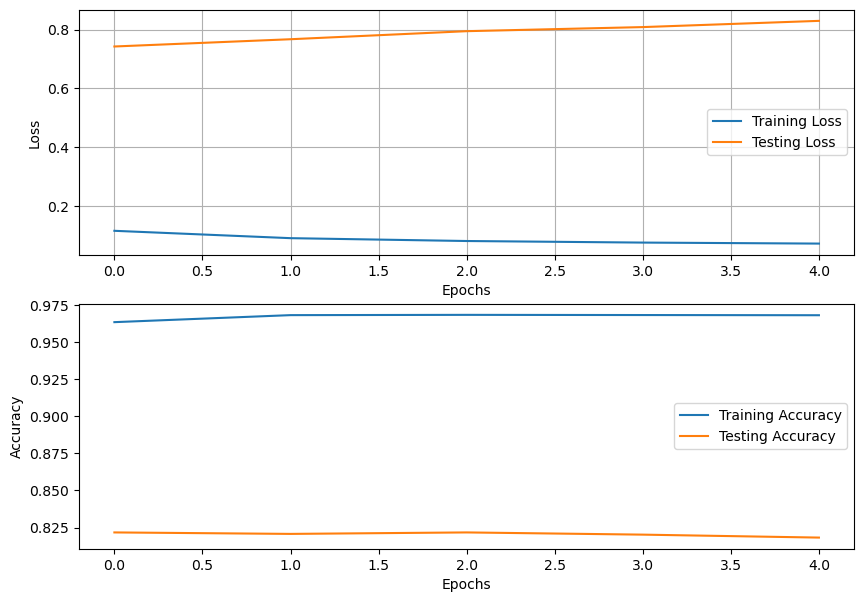

In [13]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0001)
epoch = 5
_ = train(lstm, train_loader, test_loader,optimizer, criterion,epoch,hidden_size=128,LSTM = True)

### Accuracy of Vanilla RNN - 0.792
### Accuracy of GRU - 0.829
### Accuracy of LSTM - 0.823